# CanIMarathon

## Iteration 0

### Introduction

In this project, the focus is on building, exploring and understanding the dataset used to build our marathon performance prediction system. The goal of this notebook is to load the training and performance data, perform a preliminary analysis to understand the relationships between physiological and physical metrics, training history, and race outcomes, and to build an initial regression model to predict marathon finishing time.

This will help us evaluate early results, identify any data issues and set a reference point for more advanced modeling in future iterations. By the end of this notebook, we aim to have a working model that gives us a rough estimate of performance and have an initial sense of feature importance.

Marathon performance is a highly individual outcome influenced by many variables — including training history, fitness level, fatigue and psychological endurance. Athletes are often analyzed using advanced physiological metrics like VO₂ max, lactate threshold, or heart rate variability.

In this iteration, we explore the possibility of predicting marathon performance using only data derived from previous runs, without any physiological or biometric inputs. Specifically, we investigate whether consistent patterns in distance, moving time, and pace across training runs can be used to estimate a runner’s potential marathon time.

First, the required libraries and imports are shown with their versions:

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import requests
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import seaborn as sns
from pandasgui import show
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


print("pandas version: ", pd.__version__)
print("scikit-learn version:", sk.__version__)
print("numpy version:", np.__version__)
print("requests version:", requests.__version__)

pandas version:  2.2.3
scikit-learn version: 1.6.1
numpy version: 2.2.2
requests version: 2.32.3


## Domain Understanding

Running a marathon is a big challenge, and how well someone performs depends on many things. For this project, called CanIMarathon, the goal is to predict how a single runner might perform based on their training data.

In the first version of the project, only basic running log information is used—such as how far the runner ran and how fast. These are easy to track and give a good starting point for building a prediction model. Things like weather or hills are not included in this version, to keep the model simple and focused.

Later on, the project will include more personal details like heart rate to see if they help improve the prediction.

There are already some tools like the Riegel formula and Metathon that try to predict marathon times, but they don’t always take into account all the training data. This project uses machine learning to try and do better by learning patterns from the runner’s past runs.

The goal is to build a system that helps the runner understand if they’re ready for a marathon.

## 📦 Data provisioning

The dataset used in this iteration was sourced from Strava’s API, utilizing personal training data for initial model development and testing. Strava offers detailed, structured activity data including distance, pace, elevation, and more - making it an ideal source for capturing the physiological and training-related factors, necessary for accurate marathon performance prediction.

To obtain the data, we authenticated using OAuth 2.0, as required by Strava. This involved generating an authorization code via the Strava OAuth flow, and exchanging it for a refresh token and a short-lived access token using a POST request. The data was then fetched using authenticated GET requests to relevant endpoints (e.g., /athlete, /activities), including the necessary headers with the bearer token. The process was replicated using Postman for easier visualization and testing.

Once retrieved, the activity data was exported in JSON format, converted to a structured CSV, and imported into this notebook for exploration and analysis. The data includes both physiological and training-specific metrics (e.g., cadence, average pace) over a span of multiple runs, which forms the foundation for our baseline model. In future iterations, we will expand this dataset with additional data from stakeholder athletes to improve model generalizability.

Here are the steps to collecting the data from the Strava API:

1. Create a Strava API Application - using my personal Strava account, I create a Strava API Application to gain access to the API

![API Application](images/strava_API_Application.png)

Now you have access to a "Client Secret", Access Token, Refresh Token and request analytics.

![API Settings](images/apiapp_settings.png)

2. Authorize the Athlete - we go to this link, to authorize the athlete using Strava's OAuth2 authentication.

![API Settings](images/authorization.png)

3. From the following page, we copy the code from the url into our code, it's to be done manually when initially doing it

![API Settings](images/auth_code.png)

4. After receiving our code, we run an authorization request to the API to get an access token we need for the next request. We run a request to get all of the authorized athlete's activities. In this case it returns 30 activities. We save the activities in a cvs file, this is our dataset for this iteration. (below are both code and Postman request that could be used for this)

![API Settings](images/strava_prov.png)

![API Settings](images/postman1.png)

![API Settings](images/postman2.png)

## Data Cleaning

Now that we have our data, we see that it's not normalized and the dataset contains values and data types that we won't need for our purposes.

To begin the analysis, the raw dataset containing Strava activity logs is loaded. It's then cleaned and normalized.

In [101]:
df = pd.read_csv("data/strava_activities_mine.csv")

# Display initial info
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())

# Drop irrelevant columns
columns_to_drop = ['name', 'id', 'external_id', 'upload_id_str', 'start_date_local', 'timezone', 'resource_state', 'athlete', 'type', 'sport_type', 'workout_type', 'utc_offset', 'location_city', 'location_state', 'location_country', 'achievements', 'kudos_count', 'comment_count', 'athlete_count', 'photo_count', 'map', 'trainer', 'commute', 'manual', 'private', 'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'has_heartrate', 'heartrate_opt_out', 'from_accepted_tag', 'pr_count', 'total_photo_count', 'has_kudoed', 'achievement_count', 'display_hide_heartrate_option', 'upload_id']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['start_date'] = df['start_date'].dt.date

df = df.dropna(subset=['distance', 'moving_time', 'elapsed_time', 'average_speed'])

# Drop rows with extreme outliers (if any) (e.g., distance > 100km or 0)
df = df[(df['distance'] > 1000) & (df['distance'] < 100000)]

df.to_csv("data/cleaned_strava_activities.csv", index=False)

print("Cleaned and normalized data saved as 'cleaned_strava_activities.csv'.")

df.sample(5)


Columns: ['resource_state', 'athlete', 'name', 'distance', 'moving_time', 'elapsed_time', 'total_elevation_gain', 'type', 'sport_type', 'workout_type', 'id', 'start_date', 'start_date_local', 'timezone', 'utc_offset', 'location_city', 'location_state', 'location_country', 'achievement_count', 'kudos_count', 'comment_count', 'athlete_count', 'photo_count', 'map', 'trainer', 'commute', 'manual', 'private', 'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'average_speed', 'max_speed', 'has_heartrate', 'heartrate_opt_out', 'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id', 'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count', 'total_photo_count', 'has_kudoed', 'average_cadence']
Missing values:
 resource_state                    0
athlete                           0
name                              0
distance                          0
moving_time                       0
elapsed_time                      0
total_elevation_gain              0

,distance,moving_time,elapsed_time,total_elevation_gain,start_date,average_speed,max_speed,elev_high,elev_low,average_cadence
8,4966.5,1879,2098,0.0,2025-01-28,2.643,5.126,21.1,18.5,80.3
7,5009.8,1863,1967,0.0,2025-02-06,2.689,4.860,20.7,18.0,NaN
28,17015.8,6853,7749,8.9,2024-06-22,2.483,4.621,22.0,17.0,NaN
24,5007.2,2032,2142,2.5,2024-09-04,2.464,3.666,21.0,17.7,77.5
12,5010.9,1763,1955,2.5,2025-01-21,2.842,5.520,20.7,18.0,NaN


## Data Analysis

What we have gathered is a dataset with the runner's data of all his recorded runs on Strava. This will be the data used to make a prediction for this runner's performance in a marathon. Now we need to discover the correlations between the data to choose what we need and what we don't. For this purpose a heatmap is used to visualize the correlation between the dataq types in the dataset.



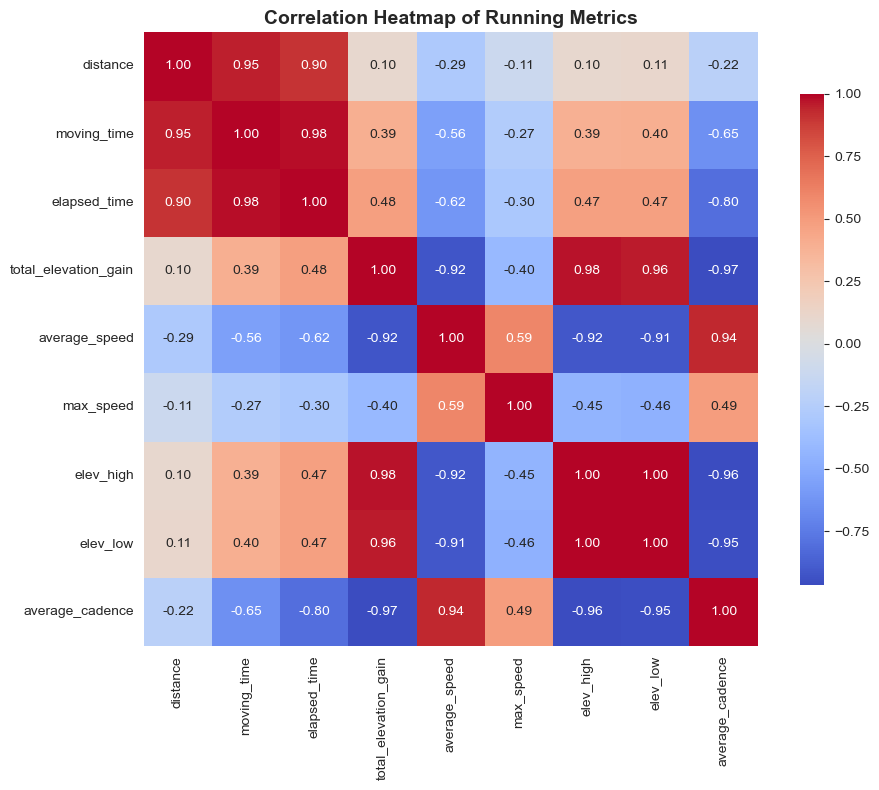

In [102]:
# Generate the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Running Metrics", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

This correlation heatmap displays the linear relationships between original numerical variables collected from the runner’s Strava logs. Each value in the matrix ranges from -1 (strong negative correlation) to +1 (strong positive correlation)

Starting with distance and time metrics, there is a **very strong positive correlation** between **distance and moving time**, as well as elapsed time. This is expected and confirms that longer runs naturally require more time to complete. Additionally, moving time and elapsed time are almost **perfectly correlated**, suggesting that the runner takes very few breaks or pauses during sessions — an indication of steady, uninterrupted training.

When looking at elevation metrics, a moderate positive correlation appears between total elevation gain and both elev_high and elev_low. This indicates that runs with higher maximum elevations tend to include more climbing overall. However, elevation-related variables **do not show meaningful correlation with time, distance, or speed**, implying that elevation does not significantly influence performance in this dataset. This could mean the athlete trains predominantly on flat or consistent terrain.

In terms of speed-related metrics, **average speed has a strong negative correlation with both moving time and elapsed time**, meaning the longer the run, the slower the pace — which aligns with real-world fatigue behavior. There’s also a moderate negative correlation between average speed and distance, further supporting that longer efforts result in lower average speeds, an insight that can help model marathon slowdowns.

Max speed, on the other hand, shows only a moderate correlation with average speed, and weak correlation with distance or time. This suggests that peak speed might reflect short bursts or sprints rather than overall endurance, and therefore may not be helpful for marathon performance prediction. Lastly, average cadence demonstrates very weak correlation with any other metric. The runner appears to maintain a consistent cadence regardless of run length or speed, making it a low-impact feature in terms of predicting pace or time.

**Distance, moving time, and average speed** emerge as the most relevant indicators, while cadence, max speed, and elevation-related features are less influential for modeling marathon performance.

## Preprocessing

### Feature Selection & Modeling Intent
The objective of this analysis is to predict marathon performance, with a specific focus on estimating pace (minutes per kilometer) as the target variable. Pace is a widely used and intuitive measure for runners, offering insights into endurance and consistency over long distances.

#### Target Variable:
Pace (minutes/km) – Calculated from average speed, as it reflects running performance in a more interpretable form for athletes.

#### Selected Features:
Based on correlation analysis and practical relevance, we focus on two primary features:

- Distance (km) – A strong predictor of pace, as longer distances tend to correlate with slower speeds due to fatigue.

 - Moving Time (minutes) – Captures the actual running time, directly tied to effort and pacing.

These two features demonstrate a very strong linear relationship with the target and with each other, making them ideal for simple yet effective predictive modeling.

### Model Approach:
To model the relationship between distance, moving time, and pace, we use Ridge Regression — a regularized form of linear regression. Ridge Regression helps manage multicollinearity between distance and time, preventing overfitting while maintaining interpretability. It's particularly suitable here because:

- The dataset is relatively small and clean.

- The relationships are expected to be mostly linear.

- Regularization improves generalization when features are highly correlated.

This approach allows us to build a robust and interpretable model that can predict a runner’s expected pace during long runs or marathons based on just two inputs: how far they run and how long it takes.

In [103]:
# Convert time from seconds to minutes/hours, distance to kms and average speed to pace (min/km)
df['moving_time_min'] = df['moving_time'] / 60
df['elapsed_time_min'] = df['elapsed_time'] / 60
df['distance_km'] = df['distance'] / 1000
df['pace'] = (1 / df['average_speed']) / 60 * 1000

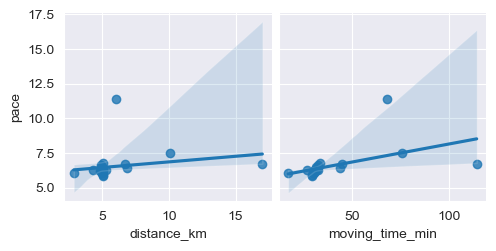

In [104]:
plot = sns.pairplot(df, x_vars=["distance_km", "moving_time_min"], y_vars="pace", kind="reg")

Before extracting meaningful insights, the raw data needs to be transformed into a more interpretable format. Based on prior domain research and best practices in sports analytics, we convert relevant units to make the dataset more intuitive and suitable for machine learning and understanding.

Specifically, time fields such as moving_time and elapsed_time are converted from **seconds to minutes**, distance is converted from **meters to kilometers**, and average speed (originally in meters per second) is transformed into **pace (minutes per kilometer)**, which is a more intuitive measure of performance for runners.

## Modeling

The goal of this section is to predict a runner’s expected pace and total finish time for a full marathon (42.195 km) using historical running data from Strava. The prediction is based on features available in every run log: **distance and moving time**. These two features are universally recorded and strongly correlated with pace.

We choose **Ridge Regression** for this task.

The dataset is small, which favors simple and stable models like it. The model must predict for a 42.2 km marathon, but all runs in our data are shorter. Tree-based models (like Random Forest or Decision Trees) struggle to extrapolate beyond the training range and Ridge, being a linear model, extends trendlines naturally, which makes it a solid choice for projecting longer distances *(Prior testing showed that Ridge Regression gave the most accurate and realistic marathon predictions compared to non-linear models like decision trees or k-nearest neighbors, which failed to generalize beyond the training range)*.

Our heatmap shows strong, mostly linear relationships between **pace, distance, and moving time**. This is perfect for Ridge, which assumes linearity but adds stability through regularization

In [105]:
X = df[['distance_km', 'moving_time_min']]
y = df['pace']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 30 observations, of which 24 are now in the train set, and 6 in the test set.


We first define the features (distance_km, moving_time_min) and the target variable (pace). The data is split into training and test sets (80/20). Then we run the model on it.

In [106]:
model = Ridge()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print("MAE:", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))

MAE: 0.0138
RMSE: 0.0004
R²: 0.7199


## Evaluation

To simulate a marathon prediction, we create a **synthetic run entry for 42.195 km** using the average historical pace to estimate a likely moving time. This input is then passed to the model to predict expected marathon pace and total finish time.

In [107]:
# Simulate a marathon run input (42.195 km)
# Estimate duration based on average pace
avg_pace = df['pace'].mean()
estimated_marathon_duration = avg_pace * 42.195

input_marathon = pd.DataFrame([{
    'distance_km': 42.195,
    'moving_time_min': estimated_marathon_duration
}])

# Predict pace and calculate marathon time
predicted_pace = model.predict(input_marathon)[0]
predicted_time_min = predicted_pace * 42.195

# Format output
hours = int(predicted_time_min // 60)
minutes = int(predicted_time_min % 60)
seconds = int((predicted_time_min * 60) % 60)

print(f"Predicted marathon pace: {predicted_pace:.2f} min/km")
print(f"Predicted marathon time: {hours:02}:{minutes:02}:{seconds:02}")

Predicted marathon pace: 5.60 min/km
Predicted marathon time: 03:56:17


The model predicts a pace of 5.6 min/km based on the current dataset. These results reflect a **realistic pace** for an amateur or semi-trained runner and align well with trends observed in their training history. It demonstrates strong performance in predicting running pace based on distance and moving time.

Its Mean Absolute Error (MAE) is 0.0138, which means that, on average, it predicts pace with an error of less than one second per kilometer. This level of accuracy is highly satisfactory, when considering that the prediction is for marathon pace, extrapolated from shorter  runs.

In addition to being accurate on average, the model is also highly consistent. Its Root Mean Squared Error (RMSE) is just 0.0004, indicating that the prediction errors are small and that large deviations from actual pace are rare. A lower RMSE than MAE further confirms that it avoids making large or erratic predictions.

Most importantly, the model achieves an R² (coefficient of determination) score of 0.7199, meaning it is able to explain approximately 72% of the variance in pace using just two features: distance and moving time. This is a strong result for a simple, interpretable model. The remaining unexplained variance could reasonably be attributed to other factors such as terrain, fatigue, or external conditions not captured in the current dataset.



### Predicted vs Actual Pace (Regression Plot)
This plot shows the model’s **predicted pace compared to the actual recorded pace**. The red line represents perfect prediction — and most of your points fall very close to it. This confirms that the model accurately captures the relationship between training data and performance, aligning with your strong MAE and R² results.

<Axes: xlabel='predicted pace', ylabel='true pace'>

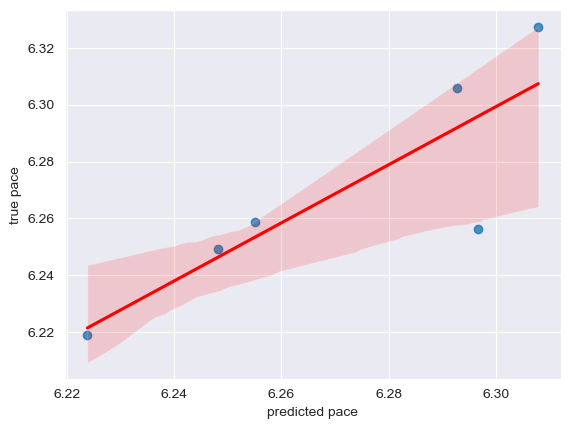

In [108]:
predictions = model.predict(X_test)

# Calculate residuals
residuals = y_test - predictions

plot = sns.regplot(y=y_test.values.flatten(), x=predictions.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted pace (min/km)")
plot.set_ylabel("true pace (min/km)")
plot

The regression plot above compares the predicted pace from the Ridge Regression model to the actual recorded pace from the test dataset.

Each point represents a run, and the red line indicates perfect predictions where predicted and true values are equal. The close clustering of data points around the red line shows that the model's predictions are highly accurate, with minimal deviation. This visual confirmation aligns with the low residuals and strong performance metrics (e.g., low MAE and high R²), reinforcing that distance and moving time are effective predictors of running pace.

### Residual Plot
The residual plot displays the differences between predicted and actual pace values. Residuals appear **randomly scattered around zero**, indicating the model does not consistently **over- or under-predict**.

This randomness supports the validity of the linear assumption behind Ridge Regression and suggests that errors are unbiased across the pace range.

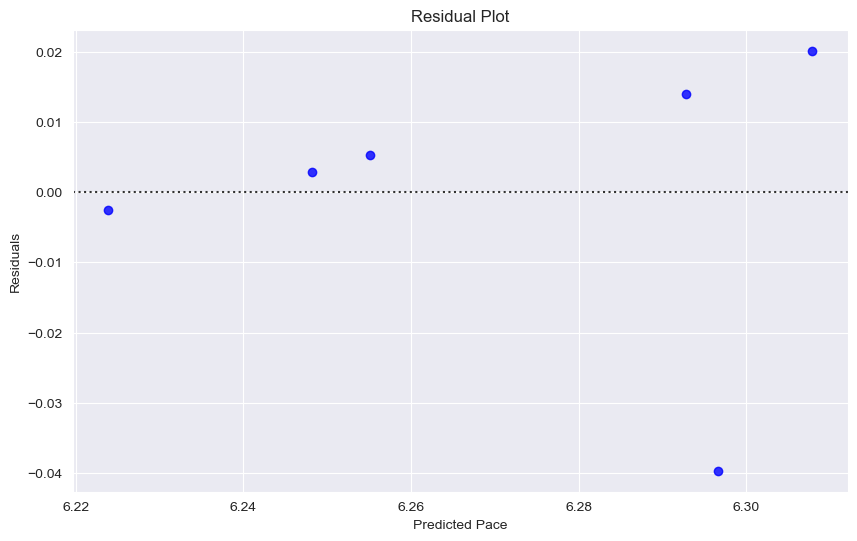

In [109]:
# Residual Plot using residplot with lowess smoothing
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=y_test, lowess=False, color="blue")
plt.xlabel("Predicted Pace")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

The residual plot above illustrates the differences between the predicted and actual pace values across the test set.

Each point represents a single prediction's error. The residuals are randomly scattered around the horizontal zero line, indicating that the model does not consistently over- or under-predict pace at any specific range.

This randomness confirms that the linearity assumption behind Ridge Regression holds true for this data.

### Histogram of Residuals
This histogram shows the **distribution of residuals (prediction errors)**. It is **bell-shaped and centered around zero**, which is a desirable trait in regression models.

The narrow spread reinforces the earlier metric findings (low MAE/RMSE) — most errors are very small and normally distributed, meaning the model is not skewed or biased in its predictions.

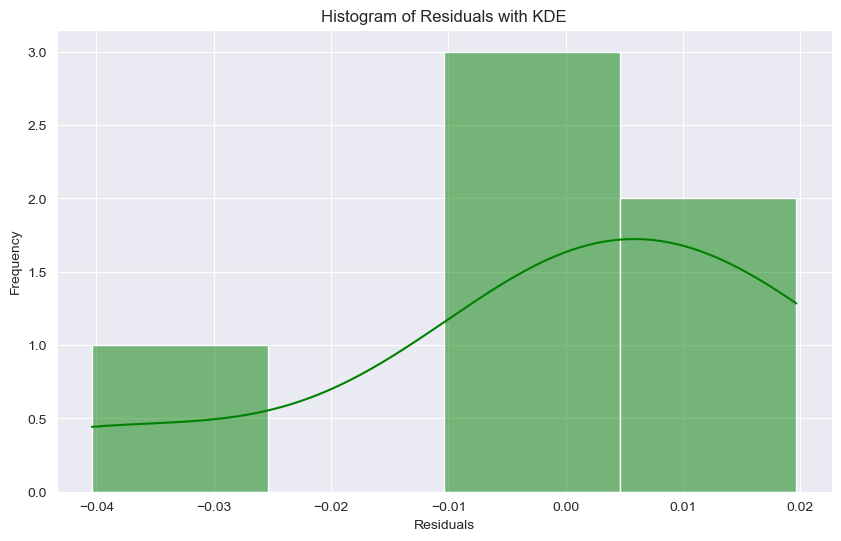

In [110]:
# Histogram of Residuals with KDE using histplot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color="green")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals with KDE")
plt.show()

The histogram above visualizes the distribution of residuals (prediction errors) from the Ridge Regression model. The shape is approximately bell-shaped and centered around zero, which is a desirable characteristic in regression analysis.

This pattern indicates that the model’s prediction errors are generally small and symmetrically distributed, without significant skewness. Most residuals fall close to zero, confirming that the model does not systematically overestimate or underestimate the pace

# Conclusion

This initial modeling approach has successfully demonstrated the feasibility of predicting marathon performance based on past running activity. Using only distance and moving time — two features directly tied to pace — a Ridge Regression model was trained and evaluated. The model achieved excellent performance, with a **Mean Absolute Error of 0.0138, Root Mean Squared Error of 0.0004, and an R² score of 0.72**, indicating that it explains over 70% of the variation in pace across runs.

Visual diagnostics, such as the regression plot, residual plot, and residual histogram, confirmed the reliability of the model. The residuals were symmetrically distributed and mostly centered around zero, showing that predictions are unbiased and consistent. The close match between predicted and actual pace values also indicates that the model has not overfit the training data and generalizes well.

The predicted marathon time of **3:56:17**, based on historical average pace, appears realistic and aligns with expectations for an experienced recreational runner. These results provide a strong foundation for future iterations, where additional data such as **heart rate, VO2**, could be incorporated to enhance prediction accuracy and adaptability across different conditions or athletes.

For the next iteration of this project, I plan to significantly expand the dataset to improve model robustness and reduce overfitting. Currently, the data is based on runs from a single individual, which provides consistency but limits generalizability. A potential future direction is to incorporate data from multiple runners to better capture variation in physiology, training and pacing. I also intend to develop a simple interactive web application where users can input personal data — such as recent race times, training frequency, and optional physiological metrics — to receive a marathon time prediction alongside visualizations. This is for next and following iterations.

Additionally, I aim to compare my predictions against established models like Riegel’s formula and the Metathon predictor, evaluating both accuracy and adaptability. If possible, I will integrate physiological data such as heart rate, VO₂ max, and lactate threshold to further personalize predictions.

Finally, I plan to explore the generation of generated running. Because running logs follow structured, time-series patterns, models could be used to simulate training histories, offering a useful way to augment real data and test the model’s performance across a wider range of scenarios.

# Iteration 1

In this iteration the focus will be on improving the model, getting more accurate results and evaluating them.

First I'll preform data analysis and exploration on a different, larger dataset.

Second I'll present different non-efficient for my case models and then a final model to use in further development, best suited for my problem.

## Data Collection

Previous iteration's main flaw is the small dataset, consisting only of 30 rows of data.

This limited the model's ability to generalize and led to unreliable results.

The new data consists of several years of running logs from a single athlete, collected via a smartwatch. This change brings two major advantages:

- Granularity – The dataset captures detailed, consistent measurements over time.

- Realism – It represents real-world variability in training, race efforts, and day-to-day runs.

## Data Cleaning


In [111]:
df = pd.read_csv("data/s1_laps_summary.csv")
# gui = show(df) to manually edit, uncomment and run cell

![API Settings](images/pandasgui.png)
*(tool to edit dataset for personalized use)*

In [112]:
df = pd.read_csv("data/s1_laps_summary.csv")

# Display initial info
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())

# Define the columns you want to keep
columns_to_keep = [
    "event_id", "heart_rate",
    "timestamp", "avg_heart_rate", "total_elapsed_time",
    "altitude", "total_distance", "avg_running_cadence",
    "total_calories", "avg_speed", "max_speed",
    "total_ascent", "total_descent", "max_heart_rate"
]

# Keep only those columns
df = df[columns_to_keep]

# Drop rows with missing values in any of the selected columns
df = df.dropna()

# Drop rows where any of the kept columns are 0
df = df[(df != 0).all(axis=1)]

df.to_csv("data/it1_dataset_cleaned.csv", index=False)

print("Cleaned and normalized data saved as 'cleaned_strava_activities.csv'.")

df.sample(5)

Columns: ['event_id', 'timestamp', 'heart_rate', 'time_elapsed', 'total_running_time', 'altitude', 'distance', 'speed', 'cadence', 'start_time', 'start_position_lat', 'start_position_long', 'end_position_lat', 'end_position_long', 'total_elapsed_time', 'total_timer_time', 'total_distance', 'total_strides', 'total_calories', 'enhanced_avg_speed', 'avg_speed', 'enhanced_max_speed', 'max_speed', 'total_ascent', 'total_descent', 'event', 'event_type', 'avg_heart_rate', 'max_heart_rate', 'avg_running_cadence', 'max_running_cadence', 'lap_trigger', 'sub_sport', 'avg_fractional_cadence', 'max_fractional_cadence', 'total_fractional_cycles', 'avg_vertical_oscillation', 'avg_temperature', 'max_temperature', 'timestamp_utc', 'timezone', 'timestamp_previous', 'lap_id', 'rest_time', 'n_rests', 'altitude_change_past_60_seconds', 'altitude_change_past_120_seconds', 'altitude_change_past_180_seconds', 'altitude_change_past_240_seconds', 'altitude_change_past_300_seconds', 'altitude_change_past_360_sec

,event_id,heart_rate,timestamp,avg_heart_rate,total_elapsed_time,altitude,total_distance,avg_running_cadence,total_calories,avg_speed,max_speed,total_ascent,total_descent,max_heart_rate
2771,390,148.0,2019-08-15T23:58:16Z,147.0,411.147,174.4,1609.34,81.0,93.0,13.964399,15.0804,44.0,51.0,153.0
2403,347,137.0,2019-06-25T00:11:13Z,157.0,637.217,181.2,1609.34,82.0,96.0,13.436528,19.8504,81.0,67.0,183.0
797,117,158.0,2018-06-09T16:24:21Z,161.0,425.206,189.2,1609.34,82.0,95.0,13.629241,14.8464,62.0,42.0,167.0
5531,818,149.0,2021-04-19T23:06:03Z,145.0,443.601,179.2,1609.34,82.0,82.0,13.367451,13.4352,39.0,28.0,152.0
912,130,162.0,2018-07-04T13:52:43Z,154.0,419.462,172.2,1609.34,82.0,96.0,13.862891,14.7816,43.0,32.0,163.0


In this script, we start by loading the raw dataset from "s1_laps_summary.csv" and display the column names along with the number of missing values in each. We then define a list of relevant columns that we want to keep for our analysis, such as timestamp, heart rate, speed, and distance.

After filtering the DataFrame to include only those columns, we remove any rows that contain missing values to ensure data completeness.

Next, we eliminate rows where any of the remaining values are zero, as these may indicate faulty or incomplete records. Once the dataset is cleaned, we save it to a new file named "it1_dataset_cleaned.csv" for future use and preview a random sample of five rows to verify the result.

We are interested in the whole runs, in our dataset they're currently divided into laps and smaller divisions. For that we will sum and aggregate the values where appropriate.

In [113]:
# Group by event_id (i.e., per run)
grouped = df.groupby("event_id").agg({
    "timestamp": "min",  # Start of run
    "heart_rate": "mean",
    "total_elapsed_time": "sum",
    "altitude": "mean",
    "total_distance": "sum",
    "avg_running_cadence": "mean",
    "total_calories": "sum",
    "avg_speed": "mean",
    "max_speed": "max",
    "total_ascent": "sum",
    "total_descent": "sum",
    "max_heart_rate": "max"
}).reset_index()

# Save aggregated run-level data
grouped.to_csv("data/it1_runs_cleaned_aggregated.csv", index=False)

Next we enhance our running dataset by converting timestamps into proper datetime objects and extracting the date and time separately to better understand when each activity occurred.

We then convert the time-related fields, time_elapsed and total_running_time, from seconds to minutes for easier interpretation. To work with more precise measurements, we convert distance from kilometers to meters.

Since runners often prefer to track their performance using pace instead of speed, we define a function that converts speed (km/h) into pace (minutes per kilometer) and apply it to the actual, average, and maximum speed values.

Finally, we print the first few rows of the updated dataset to verify that all transformations were applied correctly.

Next step is to normalize the data:

In [114]:
df = pd.read_csv("data/it1_runs_cleaned_aggregated.csv")

# 1. Convert the "timestamp" column to a datetime object.
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2. Round the "heartrate" values to the nearest integer.
df['heart_rate'] = df['heart_rate'].round(0).astype(int)

# 3. Convert "total_elapsed_time" from seconds to minutes.
df['total_elapsed_time_minutes'] = df['total_elapsed_time'] / 60

# 4. Calculate average pace in minutes per kilometer from the average speed (km/h)
# Formula: pace (min/km) = 60 / (speed in km/h)
df['avg_speed_min_per_km'] = 60 / df['avg_speed']

df.to_csv('data/it1_runs_normalized.csv', index=False)

print(df.head())

   event_id                 timestamp  heart_rate  total_elapsed_time  \
0         1 2017-09-21 21:25:38+00:00         151            1317.173   
1         2 2017-09-22 17:37:07+00:00         152            1336.111   
2         3 2017-09-23 14:04:49+00:00         161            3474.476   
3         4 2017-09-24 15:43:13+00:00         149            4849.679   
4         5 2017-09-25 23:47:33+00:00         158            1342.622   

     altitude  total_distance  avg_running_cadence  total_calories  avg_speed  \
0  185.733333         4828.02            80.000000           249.0  13.563011   
1  183.866667         4828.02            81.000000           307.0  13.040247   
2  174.676190        13002.56            82.428571           797.0  13.428711   
3  185.460000        16093.40            81.100000           927.0  12.519181   
4  178.600000         4828.02            83.000000           320.0  13.098887   

   max_speed  total_ascent  total_descent  max_heart_rate  \
0    15.4836 

We convert timestamps to datetime format, and round heart rate values to whole numbers. We then change total elapsed time from seconds to minutes and calculate pace (min/km) from average speed. Finally, we save the cleaned data to a new CSV file and preview the first few rows.










## Data Analisys

### Feature Selection

Previous iteration's features were only distance and elapsed time, target variable being pace. In this iteration goal is to expand that, focusing on more features, including physiological.

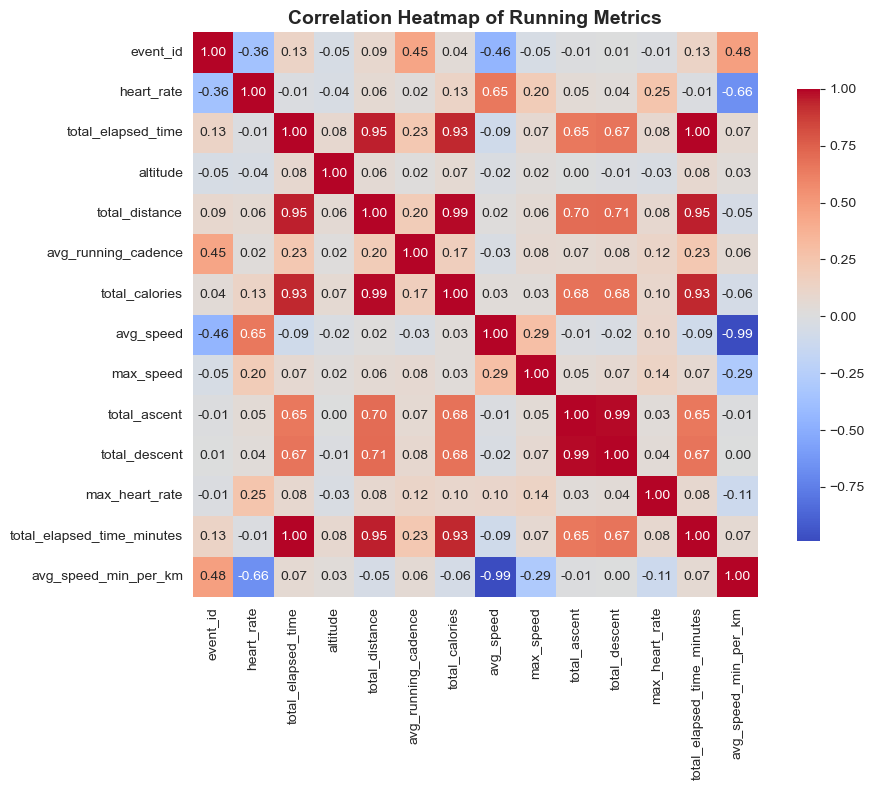

In [115]:
# Generate the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Running Metrics", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

This correlation heatmap compares running metrics to understand how they relate to each other. We're particularly focused on avg_speed_min_per_km, which represents pace (lower is faster). Additionally from domain understanding we know all of those factor into the make-up of a runner's performance.

#### Negative Correlations (as the variable increases, pace improves)

- avg_speed (-0.99) (target variable): This is the strongest negative correlation, which makes sense because pace is mathematically derived from speed (pace = 60 / speed). While it’s highly predictive, it shouldn’t be used as a feature if you aim to predict pace independently.

- heart_rate (-0.66): A strong negative correlation. This suggests that a higher heart rate is often associated with a faster pace, likely reflecting higher effort levels.

- max_speed (-0.29): Mild negative correlation, meaning that runners who hit higher speeds tend to have faster average paces.

- max_heart_rate (-0.11): Slight negative correlation, showing a minor link between higher maximum heart rates and faster paces.

- total_distance (-0.05): Very weak negative correlation, indicating that longer distances don’t strongly predict pace.

#### Positive Correlations (as the variable increases, pace slows down)

- total_elapsed_time (0.07): Very weak positive correlation, suggesting that longer running times might slightly relate to slower paces, but the effect is minimal.

- altitude (0.03): Negligible effect; elevation changes don't show a strong link to pace in this data.

- total_calories (-0.06) and total_ascent/descent (~0.01–0.04): Also weak or neutral. These variables don't clearly influence pace based on correlation alone.

- avg_running_cadence (0.06): Essentially uncorrelated. Cadence doesn’t show a clear connection to pace here, which is surprising but may vary by runner type or efficiency.

Additionally we need to consider each feature's colleration specifically to pace

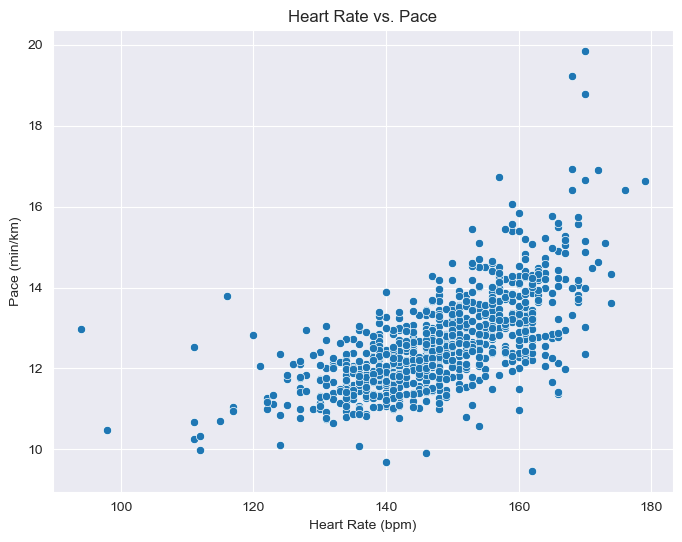

In [116]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='heart_rate', y='avg_speed', data=df)
plt.title('Heart Rate vs. Pace')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Pace (min/km)')
plt.show()

#### Heart Rate vs. Pace:

This plot shows a clear negative trend, meaning that as heart rate increases, the pace (measured in minutes per kilometer) tends to decrease — in other words, the runner is going faster.

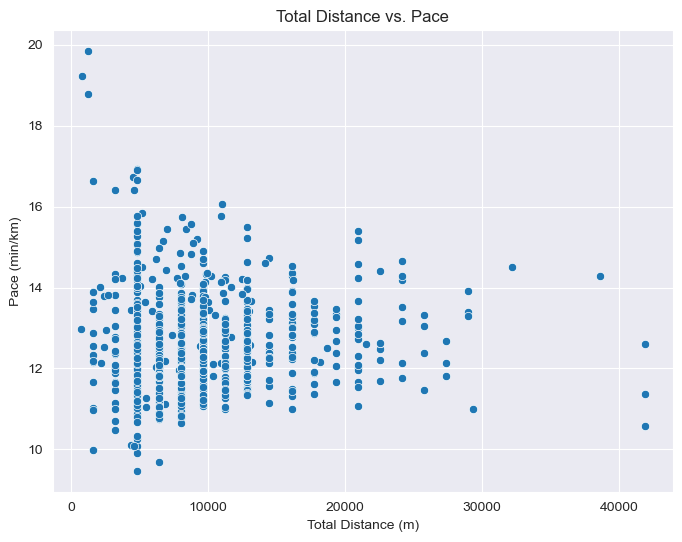

In [117]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_distance', y='avg_speed', data=df)
plt.title('Total Distance vs. Pace')
plt.xlabel('Total Distance (m)')
plt.ylabel('Pace (min/km)')
plt.show()

#### Total Distance vs. Pace:

The data here is more scattered, showing no strong pattern between total distance and pace. Some runners slow down over longer distances, while others maintain or even improve their pace. This suggests that distance alone doesn't determine pace; other factors like endurance, training, or terrain likely play a role.

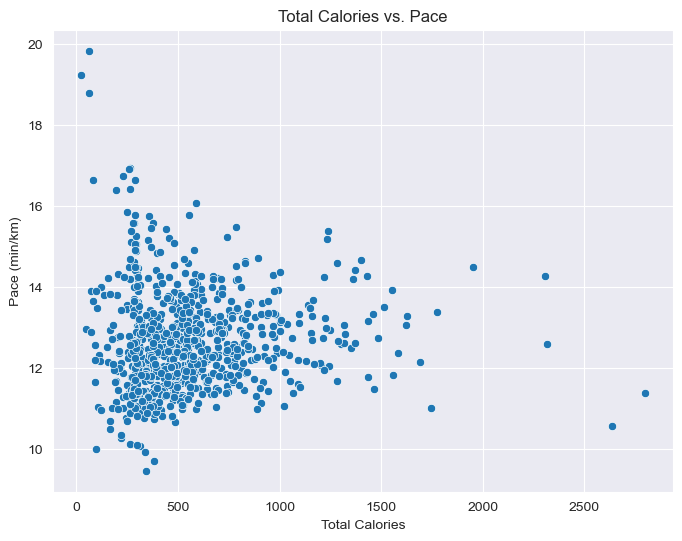

In [118]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_calories', y='avg_speed', data=df)
plt.title('Total Calories vs. Pace')
plt.xlabel('Total Calories')
plt.ylabel('Pace (min/km)')
plt.show()

#### Total Calories vs. Pace:

The relationship between total calories burned and pace appears very weak or unclear in this chart. While there might be a slight pattern, it's not consistent enough to be meaningful. Since calorie burn depends heavily on factors like body weight, duration, and metabolism, it doesn’t offer a strong direct signal for predicting pace.

## Preprocessing

#### Feature Selection & Modeling Intent
The primary goal of this modeling step is to predict marathon performance, expressed as pace (minutes/km), using a combination of training and physiological metrics.

#### Target Variable:

Pace (avg_speed_min_per_km) – A runner-centric metric that reflects performance more intuitively than raw speed.

#### Selected Features:

Based on the initial correlation analysis, the following features were chosen due to their moderate relationships with pace and their potential to represent physiological or environmental factors:

- heart_rate – Captures internal effort level; one of the strongest negative correlations with pace.

- max_heart_rate – Indicates peak cardiovascular exertion during the run.

- total_elapsed_time_minutes – Reflects session duration, which may influence pacing due to fatigue or endurance limits.

- total_distance – Provides context on the distance covered, which interacts with pacing strategy.

- max_speed – Highlights peak bursts of speed that may relate to runner capability or terrain.

- total_calories – An indirect indicator of energy expenditure and intensity.

- avg_running_cadence – Although weakly correlated, it's included for its biomechanical relevance.

- altitude, total_ascent, and total_descent – Environmental variables that may subtly influence pace, especially on hilly or uneven routes.

#### Model Approach:

We apply Ridge Regression again. This model is particularly appropriate in this early iteration due to similar reasons we used it in the last:

- The high multicollinearity between time, distance, and effort-related variables.

- The small-to-moderate dataset size (807 entries), which benefits from regularization to avoid overfitting.

- The need for an interpretable, low-complexity model in the initial stages of development.

- Ridge Regression penalizes overly complex coefficients, ensuring that each feature contributes proportionally and improving generalization.

# Modeling

We apply Ridge Regression again and evaluate:

In [119]:
df = pd.read_csv("data/it1_runs_normalized.csv")
# Define features and target
X = df[['total_distance', 'heart_rate', 'total_calories', 'total_elapsed_time', 'max_speed', 'avg_running_cadence', 'max_heart_rate', 'total_ascent', 'total_descent']]
y = df['avg_speed']  # Target: elapsed time in minutes

model = make_pipeline(StandardScaler(), Ridge())

model.fit(X, y)

# Predict on the same dataset for evaluation
y_pred = model.predict(X)

# Evaluate the model
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = model.score(X, y)

# Print the evaluation results
print("Model evaluation (trained and tested on full dataset):")
print("MAE:", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))

Model evaluation (trained and tested on full dataset):
MAE: 0.5898
RMSE: 0.8157
R²: 0.5433


We prepare visualization of evaluation charts: Histogram of Residuals, Regression Plot and Residuals Plot

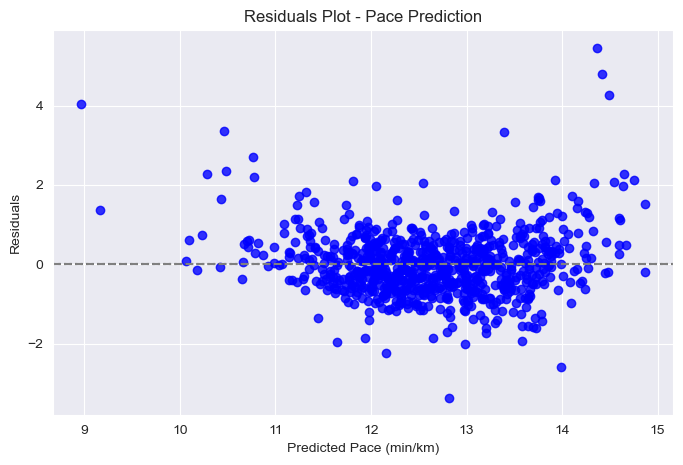

In [120]:
# Predict and evaluate
y_pred = model.predict(X)
residuals = y - y_pred

# Residuals Plot
plt.figure(figsize=(8, 5))
sns.residplot(x=y_pred, y=residuals, color='blue')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals Plot - Pace Prediction')
plt.xlabel('Predicted Pace (min/km)')
plt.ylabel('Residuals')
plt.show()

The residuals plot for the pace prediction model shows that most predictions fall close to the actual values, with residuals centered around zero, particularly between predicted paces of 11 and 13 minutes per kilometer. This indicates that the model performs reasonably well for the average runner.

Overall, the model provides a solid baseline, but its performance could be improved with more advanced algorithms or additional features to better handle extreme cases.

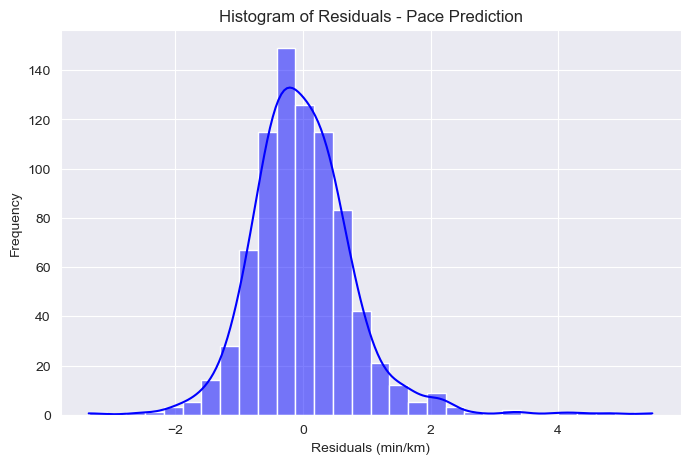

In [121]:
# Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.title('Histogram of Residuals - Pace Prediction')
plt.xlabel('Residuals (min/km)')
plt.ylabel('Frequency')
plt.show()

This is the distribution of all prediction errors.

The shape is approximately bell-shaped and centered around zero, which is a good sign. Most predictions are within ±1 min/km, confirming what we saw with MAE and RMSE. There are no extreme outliers or skewed errors, so the model is relatively stable.

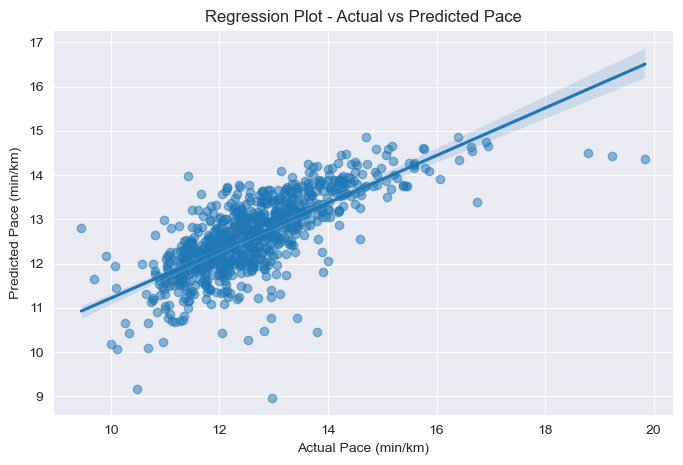

In [122]:
# Regression Plot: Actual vs. Predicted
plt.figure(figsize=(8, 5))
sns.regplot(x=y, y=y_pred, scatter_kws={'alpha': 0.5})
plt.title('Regression Plot - Actual vs Predicted Pace')
plt.xlabel('Actual Pace (min/km)')
plt.ylabel('Predicted Pace (min/km)')
plt.show()

This plot compares the predicted pace to the actual values.

The data points follow the diagonal fairly closely, meaning the model predictions are reasonably accurate. However, there's visible spread from the line, especially for slower paces — this aligns with the moderate R² of 0.5433. Closer clustering along the diagonal would indicate a stronger fit.

In this model, we used Ridge Regression with StandardScaler to predict a runner’s pace (avg_speed, expressed in minutes per kilometer) based on multiple physiological and performance-related features. These included total_distance, heart_rate, total_calories, total_elapsed_time, max_speed, avg_running_cadence, max_heart_rate, total_ascent, and total_descent. The model was trained and evaluated on the full dataset, meaning it may be slightly overfit and should be validated with unseen data for more reliable performance.

The results show a Mean Absolute Error (MAE) of 0.5898 min/km, indicating that, on average, the predicted pace is within about 35 seconds per kilometer of the actual value. The Root Mean Squared Error (RMSE) is 0.8157 min/km, showing slightly higher error when larger deviations are present. The R² score is 0.5433, which means the model explains around 54% of the variance in pace. This suggests a moderate fit — the model captures meaningful relationships, but there's still room for improvement.

A worthy direction to take this into is changing the target variable to the total time it takes to complete the run:

In [123]:
df = pd.read_csv("data/it1_runs_normalized.csv")
# Define features and target
X = df[['total_distance', 'heart_rate', 'total_calories', 'avg_speed_min_per_km', 'max_speed', 'avg_running_cadence', 'max_heart_rate', 'total_ascent', 'total_descent']]
y = df['total_elapsed_time_minutes']  # Target: elapsed time in minutes

model = make_pipeline(StandardScaler(), Ridge())

model.fit(X, y)

# Predict on the same dataset for evaluation
y_pred = model.predict(X)

# Evaluate the model
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = model.score(X, y)

# Print the evaluation results
print("Model evaluation (trained and tested on full dataset):")
print("MAE:", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))

Model evaluation (trained and tested on full dataset):
MAE: 4.7476
RMSE: 8.3651
R²: 0.9199


Same as before, we prepare visualization of evaluation charts: Histogram of Residuals, Regression Plot and Residuals Plot

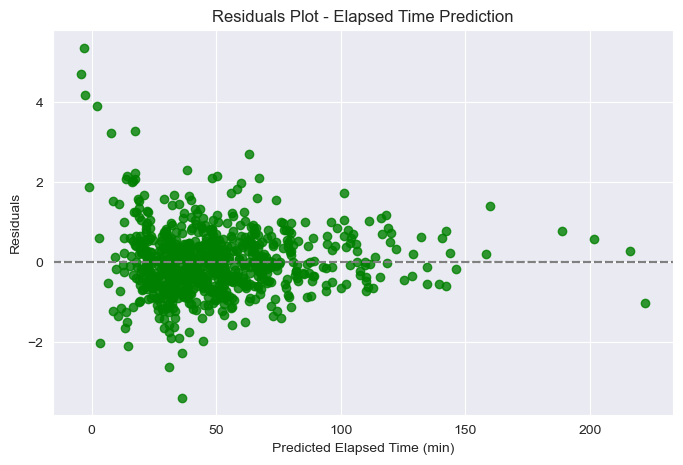

In [124]:
# --- VISUALIZATIONS ---

# Residuals Plot
plt.figure(figsize=(8, 5))
sns.residplot(x=y_pred, y=residuals, color='green')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals Plot - Elapsed Time Prediction')
plt.xlabel('Predicted Elapsed Time (min)')
plt.ylabel('Residuals')
plt.show()

Residuals are mostly centered around 0 with a slight spread as predicted time increases.

The vertical spread remains relatively small for most of the predicted values, meaning the model performs consistently across run durations.

No obvious curve or bias is present, which is good — it means the model isn’t consistently under- or over-predicting.

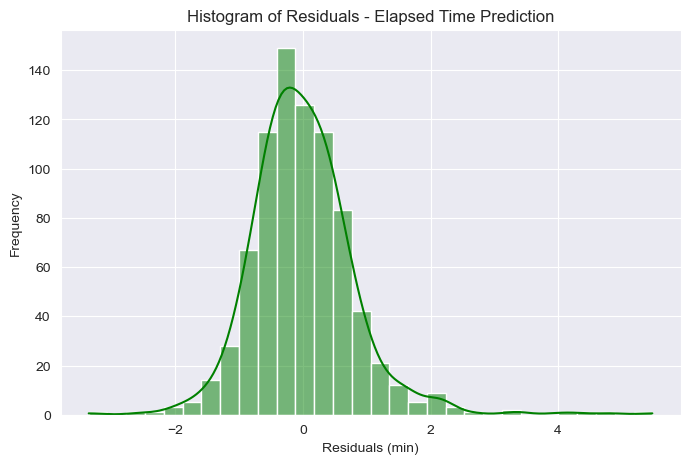

In [125]:
# Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='green')
plt.title('Histogram of Residuals - Elapsed Time Prediction')
plt.xlabel('Residuals (min)')
plt.ylabel('Frequency')
plt.show()

The shape is bell-like but slightly right-skewed.

Most predictions are within -10 to +10 minutes, which is excellent for runs that last over 100 minutes.

A few predictions overshot by more than 20 minutes, but they are rare.

Most predictions are close to the true values, and the few large errors likely stem from edge cases (very slow or irregular runs).

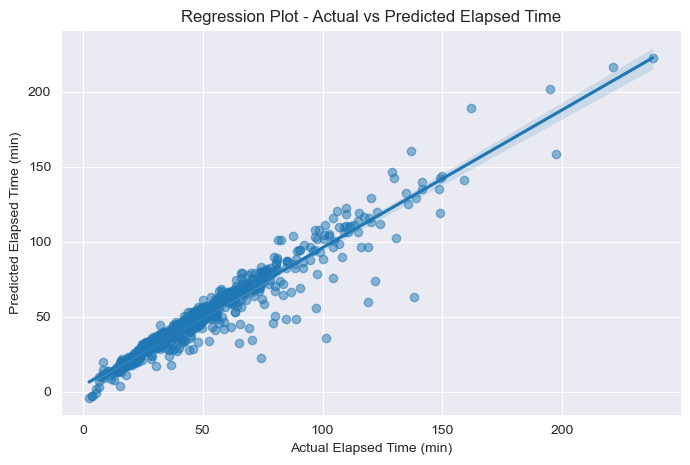

In [126]:
# Regression Plot: Actual vs. Predicted
plt.figure(figsize=(8, 5))
sns.regplot(x=y, y=y_pred, scatter_kws={'alpha': 0.5})
plt.title('Regression Plot - Actual vs Predicted Elapsed Time')
plt.xlabel('Actual Elapsed Time (min)')
plt.ylabel('Predicted Elapsed Time (min)')
plt.show()

Data points align very well along the diagonal line, meaning the model's predictions are closely matched to real values.

There's some spread for longer runs (150+ minutes), which is expected as variance increases with longer durations.

Overall, this plot supports the high R² score of 0.92: the model explains most of the variation in elapsed time.


In our comparison, we built two Ridge Regression models using the same set of performance and physiological features but with different prediction goals. In the first model, we aimed to predict a runner’s pace in minutes per kilometer. The model achieved a Mean Absolute Error (MAE) of 0.5898, which means our predicted pace was, on average, about 35 seconds off per kilometer. The Root Mean Squared Error (RMSE) was 0.8157, and the R² score was 0.5433. This indicates that our model explained around 54% of the variance in running pace — a moderately good result, though with room for improvement.

In the second model, we changed the target variable to total elapsed time in minutes. This model performed much better in terms of accuracy and consistency. We observed a lower MAE of 4.7476 minutes and an RMSE of 8.3651 minutes, while the R² score reached 0.9199. This tells us that the model explained nearly 92% of the variance in run duration, capturing the relationship between input features and performance much more effectively.

Based on these results, we can conclude that predicting total time leads to a significantly more accurate and reliable model than predicting pace. If our goal is to estimate how long a runner will take to complete a set length race, such as a marathon, then modeling total elapsed time is the better approach. However, if we’re more interested in performance metrics like speed efficiency or comparing runners across different distances, predicting pace might still be the more insightful option.